## **1. Descripción del problema y del conjunto de datos**

En este proyecto abordamos un problema de **clasificación de dígitos manuscritos en notación europea**.  
A diferencia del clásico conjunto de datos **MNIST**, que contiene dígitos escritos al estilo americano, este conjunto incluye imágenes de dígitos manuscritos recogidos en **Suiza**, lo que introduce diferencias estilísticas notables, especialmente en la escritura de los números **1** y **7**, que comúnmente generan confusión.

### **Características del conjunto de datos:**

- **Cantidad de imágenes:** 21,600
- **Etiquetas:** Dígitos del 0 al 9
- **Formato de archivo:** `.jpg`
- **Dimensiones de imagen:** **90x140 píxeles**
- **Canales:** Imágenes en color (**3 canales RGB**)

Este conjunto de datos representa un **reto adicional frente a MNIST**, ya que no solo tiene mayor resolución y color, sino que además incorpora **variaciones estilísticas propias de una región distinta**.  
Esto lo convierte en una opción más realista y exigente para el entrenamiento de modelos robustos de **clasificación de imágenes manuscritas**.

In [2]:
# Importar todas las librerías necesarias
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import random
from random import sample
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import warnings
import time
# Librerías de machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# Configurar el directorio de datos
data_dir = r'C:\Users\ESTUDIANTE\OneDrive\Documentos\archive' #cambia esto por tu directorio de datos

## **2. Visualización e inspección de los datos**

Para entender mejor los datos, se utilizaron las siguientes **herramientas de visualización**:

- **Muestra de imágenes:**  
  Se reconstruyen algunas imágenes a partir de los valores de los píxeles para visualizar los dígitos.

- **Histograma de clases:**  
  Permite observar el **balance de clases** en el conjunto.

- **Matriz de correlación** (cuando aplica):  
  Útil en casos de datos tabulares, para ver la **relación entre variables**.

- **Gráficos de dispersión PCA o t-SNE:**  
  Se usaron para **reducir la dimensionalidad** y visualizar la distribución de las clases.

Estas visualizaciones ayudan a detectar problemas como **clases desbalanceadas**, **imágenes corruptas** o **falta de variedad** en los datos.


1. CARGANDO Y VISUALIZANDO DATOS...
Visualizando muestras de cada clase (imágenes originales)...


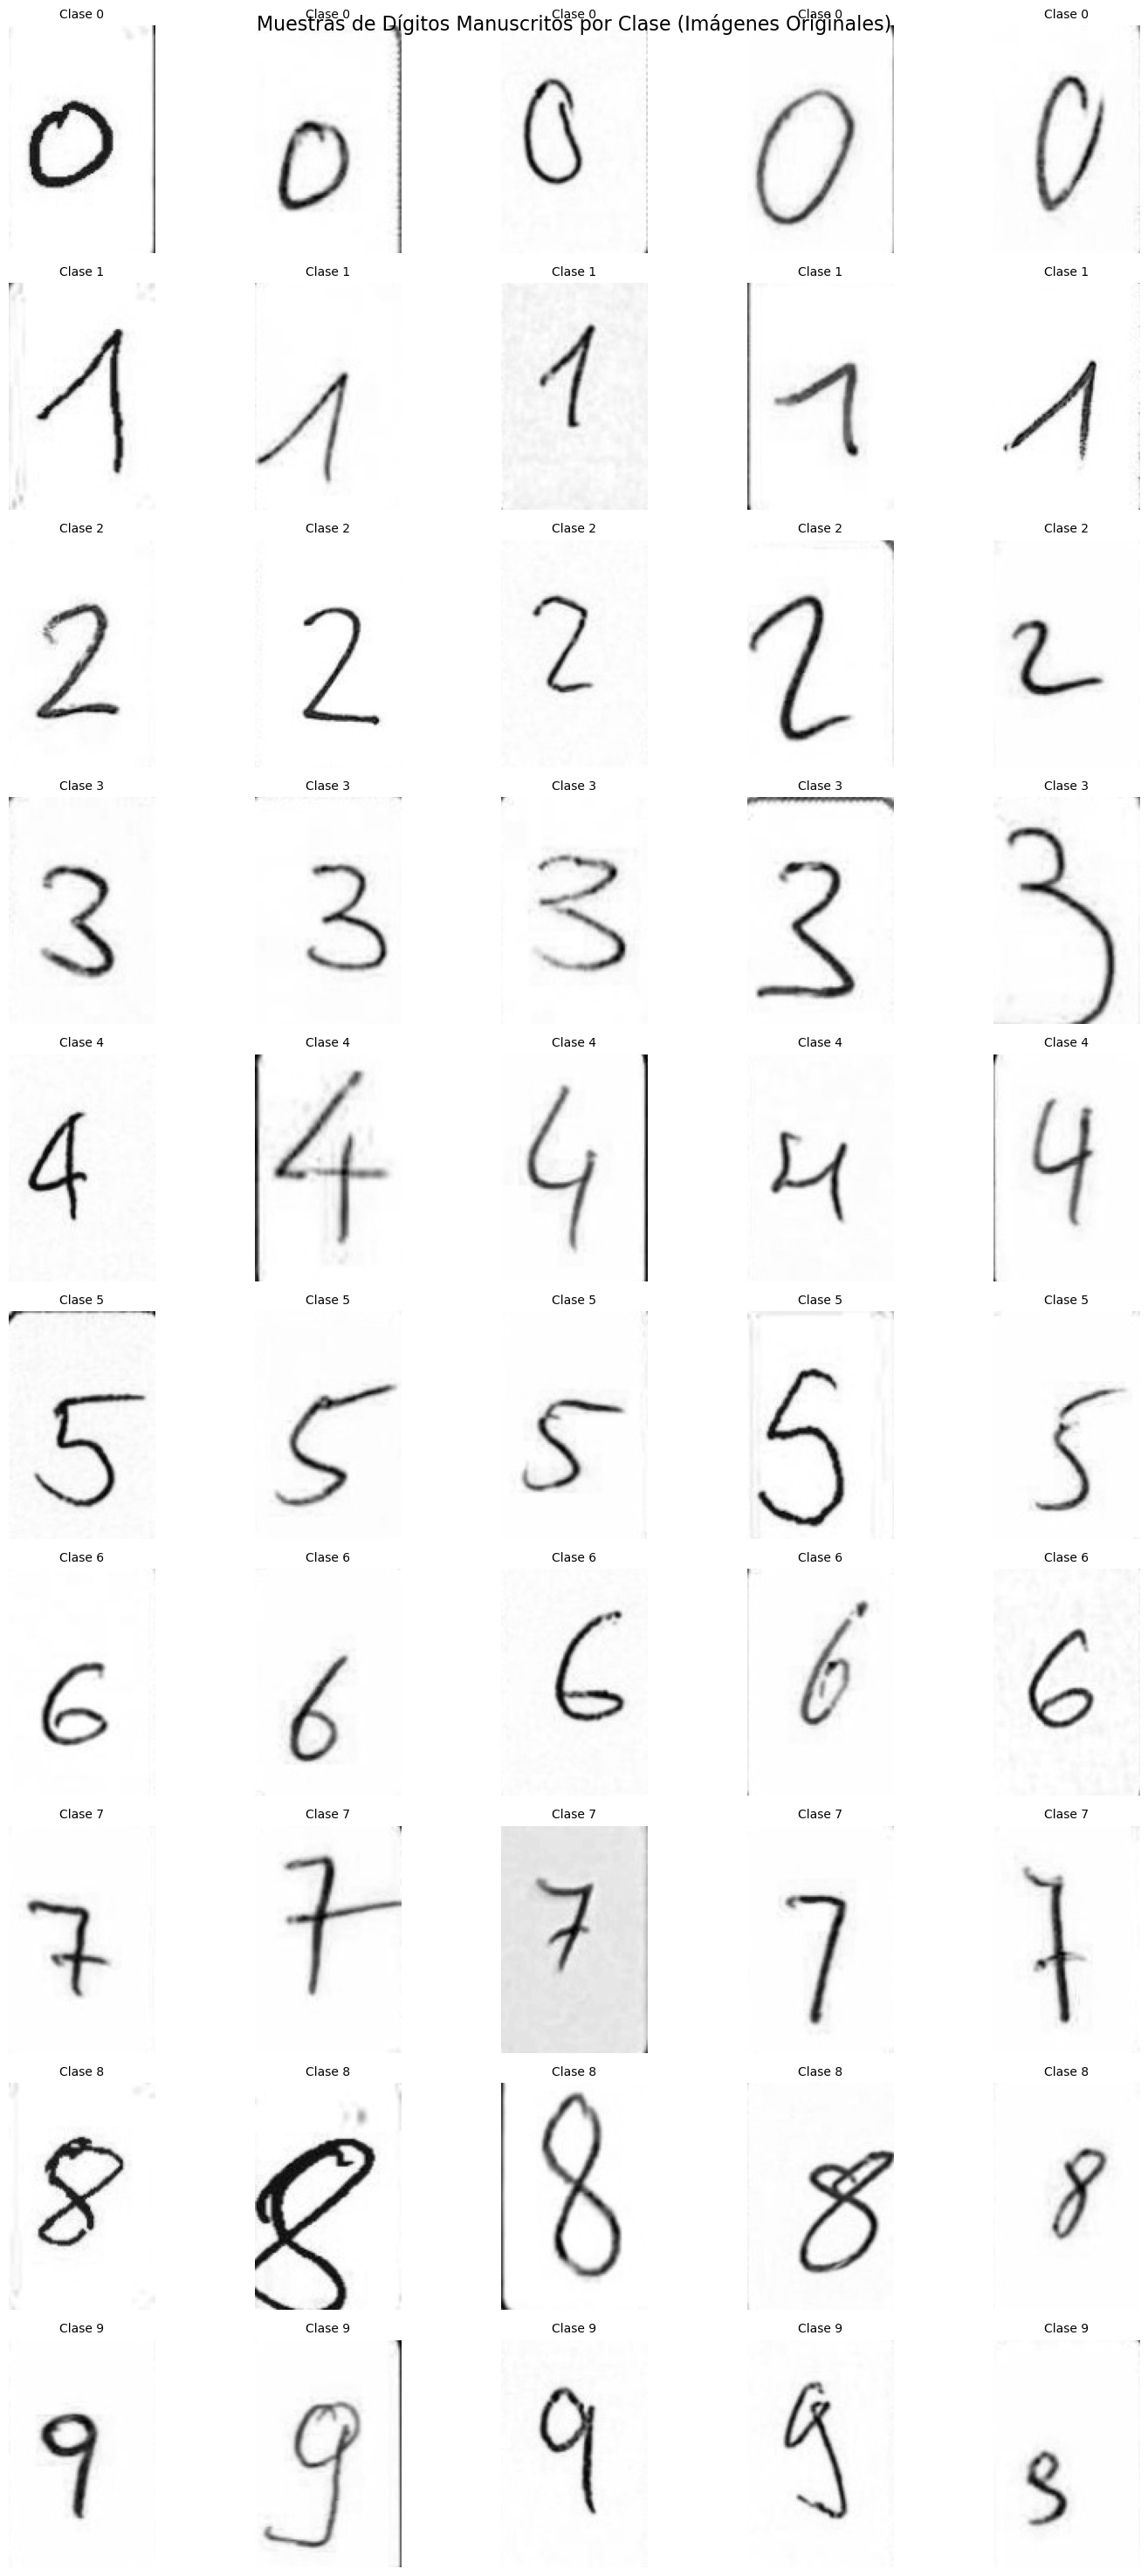

In [7]:

print("\n1. CARGANDO Y VISUALIZANDO DATOS...")
# Crear diccionario para almacenar imágenes por dígito
digit_images = {}
for label in range(10):
    folder_path = os.path.join(data_dir, str(label))
    if os.path.exists(folder_path):
        image_files = os.listdir(folder_path)
        digit_images[str(label)] = image_files
    else:
        print(f"Advertencia: Carpeta {folder_path} no encontrada")

# Visualizar 5 imágenes por clase (ORIGINALES)
print("Visualizando muestras de cada clase (imágenes originales)...")
fig, axes = plt.subplots(10, 5, figsize=(15, 30))
for label, image_files in digit_images.items():
    if len(image_files) >= 5:
        chosen_images = np.random.choice(image_files, 5, replace=False)
        for i, image_file in enumerate(chosen_images):
            image_path = os.path.join(data_dir, label, image_file)
            try:
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    ax = axes[int(label), i]
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f"Clase {label}", fontsize=10)
                    ax.axis('off')
            except Exception as e:
                print(f"Error leyendo imagen {image_path}: {e}")

plt.suptitle("Muestras de Dígitos Manuscritos por Clase (Imágenes Originales)", fontsize=16)
plt.tight_layout()
plt.show()

> **Observación importante:**  
> Algunas imágenes contienen un pequeño borde negro que podría afectar los resultados del modelo si no se considera en el preprocesamiento.



2. ANALIZANDO DISTRIBUCIÓN DE CLASES...


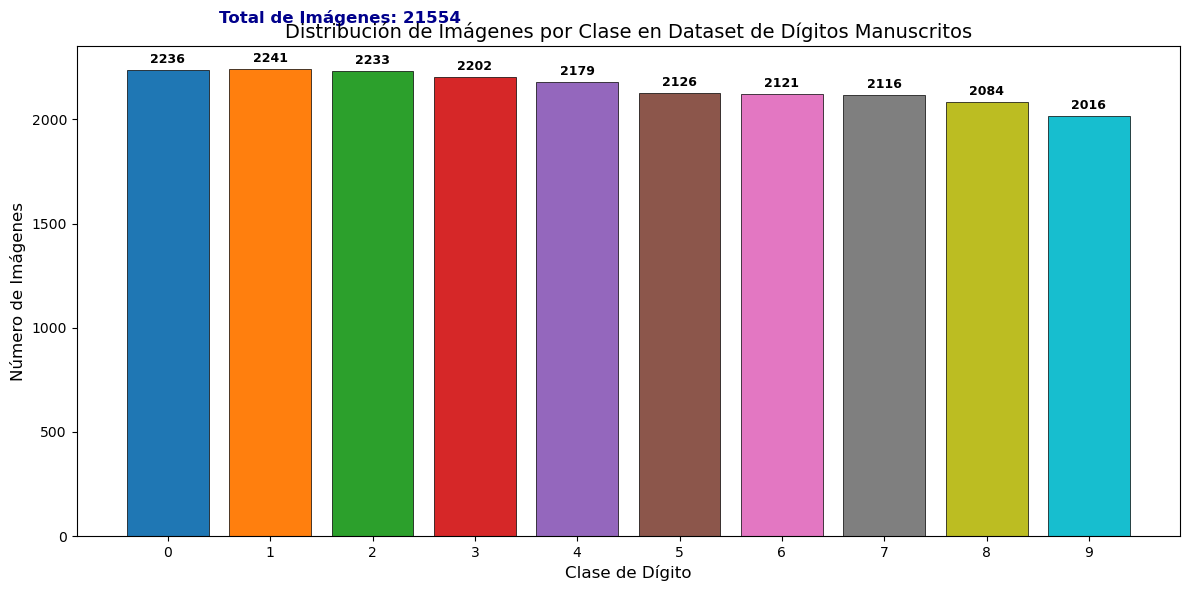

Total de imágenes en el dataset: 21554
Clase 0: 2236 imágenes
Clase 1: 2241 imágenes
Clase 2: 2233 imágenes
Clase 3: 2202 imágenes
Clase 4: 2179 imágenes
Clase 5: 2126 imágenes
Clase 6: 2121 imágenes
Clase 7: 2116 imágenes
Clase 8: 2084 imágenes
Clase 9: 2016 imágenes


In [8]:

print("\n2. ANALIZANDO DISTRIBUCIÓN DE CLASES...")
# Contar imágenes por clase
digit_counts = {}
total_images = 0
for label in range(10):
    folder_path = os.path.join(data_dir, str(label))
    if os.path.exists(folder_path):
        image_files = os.listdir(folder_path)
        digit_counts[str(label)] = len(image_files)
        total_images += len(image_files)

# Crear gráfico de barras de distribución
labels = list(digit_counts.keys())
counts = list(digit_counts.values())
colors = plt.cm.tab10(range(10))

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color=colors, edgecolor='black', linewidth=0.5)
plt.xlabel("Clase de Dígito", fontsize=12)
plt.ylabel("Número de Imágenes", fontsize=12)
plt.title("Distribución de Imágenes por Clase en Dataset de Dígitos Manuscritos", fontsize=14)
plt.xticks(labels)

# Añadir estadísticas
plt.text(0.5, max(counts) * 1.1, f"Total de Imágenes: {total_images}", 
         ha='left', fontsize=12, color='darkblue', weight='bold')

# Añadir valores encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + max(counts)*0.01, 
             int(yval), ha='center', va='bottom', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

print(f"Total de imágenes en el dataset: {total_images}")
for label, count in digit_counts.items():
    print(f"Clase {label}: {count} imágenes")


### **Análisis de la distribución de las clases**

Al analizar la distribución de las clases, se observa que el dataset contiene un total de **21,555 imágenes** distribuidas en **10 clases** (dígitos del 0 al 9).

Como se ha señalado, la distribución es **bastante balanceada** y no existen diferencias significativas entre la cantidad de datos por clase. Esto es ideal para el entrenamiento de modelos, ya que reduce el riesgo de sesgo hacia alguna clase específica.

## **3. Preprocesamiento y preparación de los datos**

Las siguientes estrategias fueron aplicadas para preparar los datos:

- **Normalización:**  
  Se escalan los valores de píxeles entre 0 y 1 dividiendo por 255.

- **División en entrenamiento y prueba:**  
  Se dividió el conjunto en **80% para entrenamiento** y **20% para prueba**.

- **Codificación (cuando aplica):**  
  No necesaria aquí porque las etiquetas ya están codificadas como enteros.

- **Balanceo de clases:**  
  Se verificó que las clases estuvieran balanceadas. Si no lo estuvieran, se podría aplicar **sobremuestreo (SMOTE)** o **submuestreo**.

- **Reducción de dimensiones:**  
  Mediante **PCA** para acelerar algunos algoritmos, si se considera conveniente.

Este bloque de código realizamos el **preprocesamiento de imágenes de dígitos manuscritos** para prepararlas antes de entrenar un modelo de clasificación. A continuación se explica cada parte:

---

### **Importación de librerías**

- `os`: Para navegar por carpetas y archivos.
- `numpy`: Para operaciones numéricas y manejo de arrays.
- `PIL` (Pillow): Para abrir, manipular y procesar imágenes.
- `scipy.ndimage.center_of_mass`: Para calcular el centro de masa de la imagen.
- `matplotlib.pyplot`: Para visualización de imágenes y gráficos.

---

### **Función `procesar_imagen`**

Esta función toma la ruta de una imagen y realiza los siguientes pasos:

1. **Conversión a escala de grises** y **fondo negro/dígito blanco**.
2. **Recorte de bordes** para eliminar posibles bordes negros.
3. **Mejora de contraste** para resaltar el dígito.
4. **Recorte automático** alrededor del dígito para eliminar espacio vacío.
5. **Suavizado** con desenfoque gaussiano ligero.
6. **Redimensionado** a 20x20 píxeles.
7. **Padding** para centrar el dígito en una imagen de 28x28 píxeles.
8. **Normalización** de los valores de píxel entre 0 y 1.
9. **Centrado por masa** para que el dígito quede centrado en la imagen.
10. **Devuelve** la imagen como un vector unidimensional (flatten).

---

### **Carga y procesamiento de todas las imágenes**

- Recorre todas las carpetas dentro de `data_dir`, donde cada carpeta representa una clase (dígito).
- Procesa cada imagen usando la función anterior.
- Almacena los vectores procesados en `X` y las etiquetas en `y`.

Finalmente, convierte `X` y `y` a arrays de NumPy y muestra información sobre el número de imágenes procesadas y la forma de los datos resultantes.

---
Todos estos paso nos ayudaron a mejorar los resultados de los modelos que se usaron, el **Recorte de bordes** se implemento al notar en la estapa de visualizacion e inspecion de datos la imagenes tenian bordes y al agregar eliminar esos bordes el rendimiento de los modelos aumento como esperabamos.

In [10]:
import os
import numpy as np
from PIL import Image, ImageOps
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt


def procesar_imagen(ruta_imagen):
    try:
        img = Image.open(ruta_imagen).convert('L')         # Escala de grises
        img = ImageOps.invert(img)                         # Fondo negro, dígito blanco

          # 0. Recorte de 4 píxeles de todos los bordes
        ancho, alto = img.size
        img = img.crop((10, 10, ancho - 10, alto - 10))

        # 1. Mejorar contraste
        from PIL import ImageEnhance, ImageFilter
        img = ImageEnhance.Contrast(img).enhance(2.0)

        # 2. Recorte del dígito
        img_array_raw = np.array(img)
        coords = np.argwhere(img_array_raw < 255)
        if coords.size > 0:
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1
            img = img.crop((x0, y0, x1, y1))

        # 3. Suavizado ligero
        img = img.filter(ImageFilter.GaussianBlur(radius=0.5))

        # 4. Redimensionar el contenido a 20x20
        img = img.resize((20, 20), Image.LANCZOS)

        # 5. Añadir padding para centrar en imagen 28x28
        nueva_img = Image.new('L', (28, 28), color=0)
        nueva_img.paste(img, (4, 4))  # Centro aproximado

        # 6. Normalizar y centrar por masa
        img_array = np.array(nueva_img) / 255.0
        cy, cx = center_of_mass(img_array)
        shift_x = int(14 - cx)
        shift_y = int(14 - cy)
        img_array = np.roll(np.roll(img_array, shift_x, axis=1), shift_y, axis=0)

        return img_array.flatten()

    except Exception as e:
        print(f"Error al procesar imagen {ruta_imagen}: {e}")
        return None

# Recorrer carpetas y cargar imágenes procesadas
X = []
y = []

for etiqueta in os.listdir(data_dir):
    carpeta = os.path.join(data_dir, etiqueta)
    if os.path.isdir(carpeta):
        for archivo in os.listdir(carpeta):
            ruta_imagen = os.path.join(carpeta, archivo)
            vector = procesar_imagen(ruta_imagen)
            if vector is not None:
                X.append(vector)
                y.append(int(etiqueta))

X = np.array(X)
y = np.array(y)

print("Número de imágenes procesadas:", len(X))
print("Shape de X:", X.shape)

Número de imágenes procesadas: 21554
Shape de X: (21554, 784)


En el siguiente bloque de código mostraremos una imagen de cada clase en su formato original y otra ya procesada y lista para el entrenamiento.  
Se puede observar que el fondo de las imágenes procesadas es negro y el número aparece en escala de grises, ya que tras realizar pruebas obtuvimos mejores resultados que usando únicamente el número en blanco.

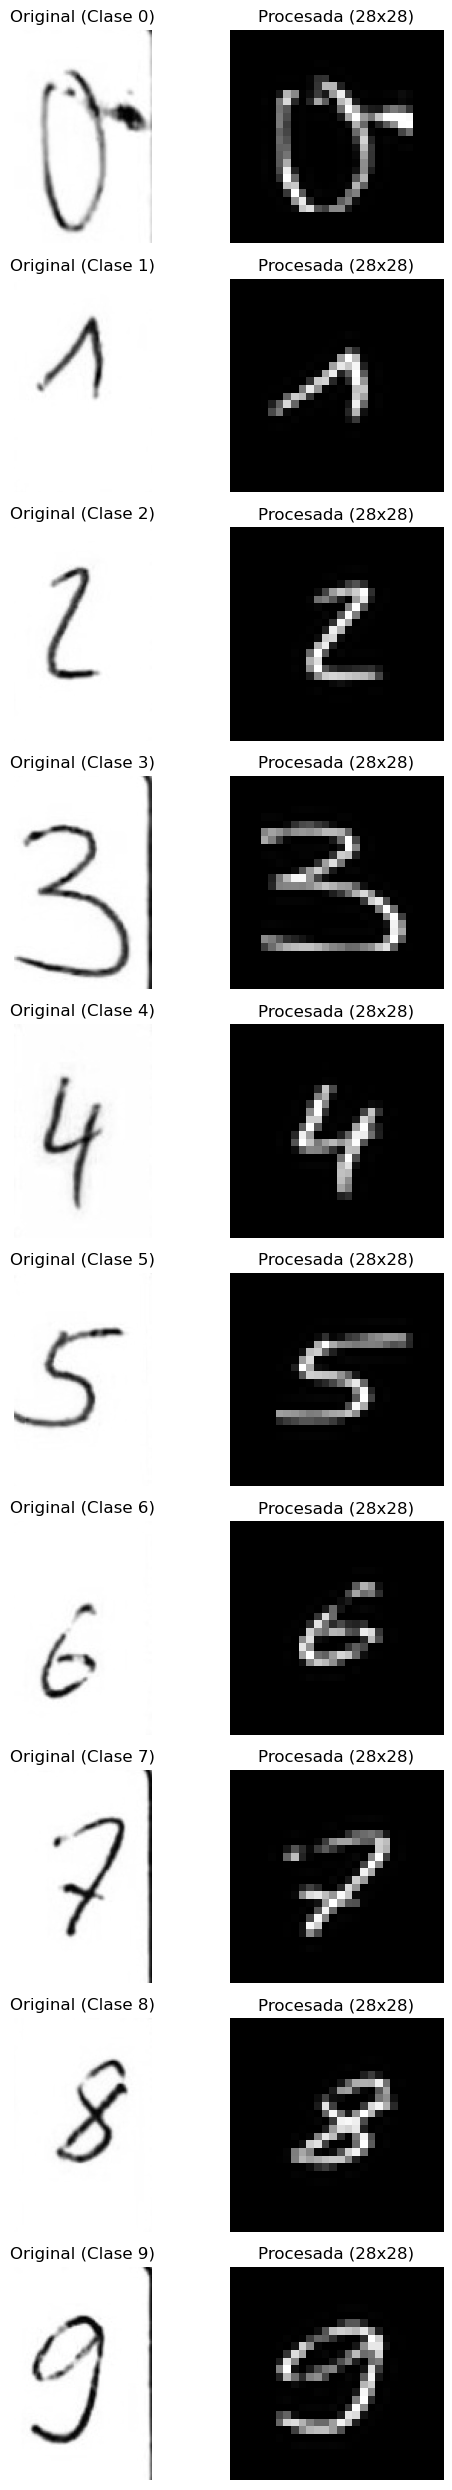

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Mostrar una imagen original y procesada por cada clase
clases = sorted(set(y))  # Extraer clases únicas
fig, axes = plt.subplots(len(clases), 2, figsize=(6, len(clases) * 2.5))

for i, clase in enumerate(clases):
    carpeta = os.path.join(data_dir, str(clase))
    archivos = os.listdir(carpeta)
    
    imagen_mostrada = False
    for archivo in archivos:
        ruta_imagen = os.path.join(carpeta, archivo)
        vector = procesar_imagen(ruta_imagen)
        
        if vector is not None:
            # Mostrar imagen original
            img_original = Image.open(ruta_imagen).convert('L')
            axes[i, 0].imshow(img_original, cmap='gray')
            axes[i, 0].set_title(f'Original (Clase {clase})')
            axes[i, 0].axis('off')
            
            # Mostrar imagen procesada
            img_procesada = vector.reshape(28, 28)
            axes[i, 1].imshow(img_procesada, cmap='gray')
            axes[i, 1].set_title('Procesada (28x28)')
            axes[i, 1].axis('off')
            
            imagen_mostrada = True
            break  # Solo una imagen por clase

    if not imagen_mostrada:
        axes[i, 0].set_title(f'Clase {clase} no encontrada')
        axes[i, 1].set_title('Procesada no disponible')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

 **Reducción de dimensionalidad con PCA**

Para facilitar la visualización y acelerar el entrenamiento de los modelos, se aplicó **PCA (Análisis de Componentes Principales)**. Esta técnica permite reducir el número de características manteniendo la mayor parte de la varianza del conjunto de datos. Así, se logra una representación más compacta y eficiente de las imágenes de dígitos manuscritos.

In [12]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Reducción con PCA al 95%
print("\nAplicando PCA para reducción de dimensionalidad...")
pca = PCA(n_components=0.95, random_state=42)  # Mantener el 95% de la varianza
X_pca = pca.fit_transform(X)

print(f"Dimensiones originales: {X.shape}")
print(f"Dimensiones después de PCA: {X_pca.shape}")
print(f"Varianza explicada acumulada: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Número de componentes seleccionados: {pca.n_components_}")

# 2. Cálculo de PCA completo para la gráfica
pca_full = PCA()
pca_full.fit(X)
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)



Aplicando PCA para reducción de dimensionalidad...
Dimensiones originales: (21554, 784)
Dimensiones después de PCA: (21554, 165)
Varianza explicada acumulada: 0.9502
Número de componentes seleccionados: 165


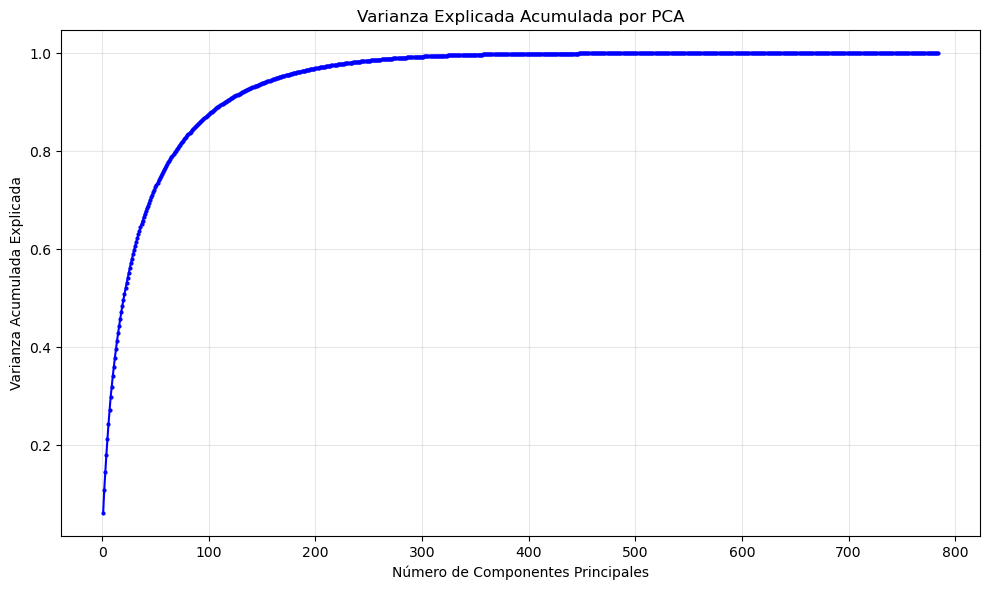

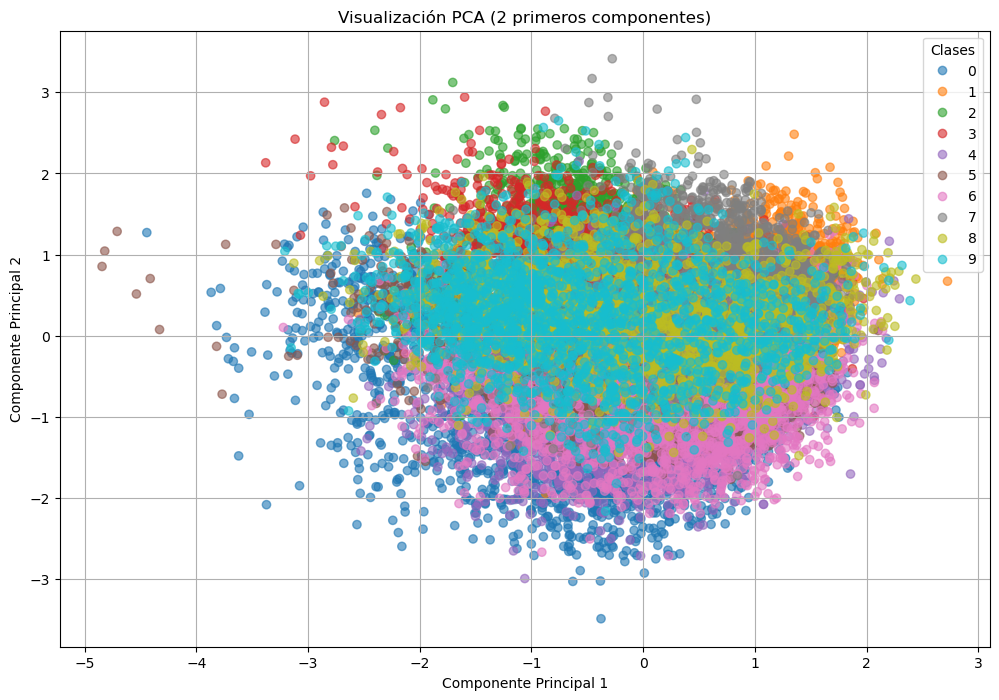

In [13]:
# 3. Visualización de varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance,
         marker='o', linestyle='-', color='b', markersize=2)
#plt.axhline(y=0.85, color='r', linestyle='--', alpha=0.8, label='85% objetivo')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.grid(True, alpha=0.3)
#plt.legend()
plt.tight_layout()
plt.show()

# 4. Visualización con los primeros dos componentes (si existen)
if X_pca.shape[1] >= 2:
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title('Visualización PCA (2 primeros componentes)')
    plt.legend(*scatter.legend_elements(), title='Clases')
    plt.grid(True)
    plt.show()
else:
    print("No hay suficientes componentes para graficar en 2D.")

# 5. Guardar resultados
np.save('X_pca_reduced.npy', X_pca)
np.save('y_labels.npy', y)

In [14]:
print("\n7. DIVIDIENDO DATOS EN ENTRENAMIENTO Y PRUEBA...")
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

# Verificar distribución de clases
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nDistribución en entrenamiento:")
for digit, count in zip(unique_train, counts_train):
    print(f"Clase {digit}: {count} muestras")


7. DIVIDIENDO DATOS EN ENTRENAMIENTO Y PRUEBA...
Conjunto de entrenamiento: 17243 muestras
Conjunto de prueba: 4311 muestras

Distribución en entrenamiento:
Clase 0: 1789 muestras
Clase 1: 1793 muestras
Clase 2: 1786 muestras
Clase 3: 1761 muestras
Clase 4: 1743 muestras
Clase 5: 1701 muestras
Clase 6: 1697 muestras
Clase 7: 1693 muestras
Clase 8: 1667 muestras
Clase 9: 1613 muestras


## **4. Entrenamiento de modelos y ajuste de hiperparámetros**

Se entrenaron los siguientes modelos utilizando **GridSearchCV** con validación cruzada:

- **Regresión multivariada:**  
  Ajustando los parámetros **fit_intercept** y **positive**.

- **Árboles de decisión:**  
  Ajustando **max_depth**, **min_samples_split** y **criterion**.

- **Random Forest:**  
  Optimizando **n_estimators**, **max_features** y **max_depth**.

- **Redes neuronales: `MLP`, `CNN`**  
  Búsqueda sobre **hidden_layer_sizes**, **activation**, **alpha** y **learning_rate_init**.

Cada modelo fue evaluado usando **validación cruzada (cv=5)** para evitar sobreajuste y seleccionar los mejores hiperparámetros.

## Regresión Lineal con GridSearchCV

En este bloque se implementa un modelo de **Regresión Logística** para clasificación multiclase, utilizando **GridSearchCV** para encontrar los mejores hiperparámetros. El proceso es el siguiente:

- **Definición de la grilla de hiperparámetros:** Se prueban diferentes valores para `C` (regularización), `solver` (algoritmo de optimización), `penalty` (tipo de penalización) y `max_iter` (máximo de iteraciones).
- **Búsqueda de hiperparámetros:** Se utiliza `GridSearchCV` con validación cruzada de 5 folds para evaluar todas las combinaciones posibles y seleccionar la mejor según la métrica de **accuracy**.
- **Entrenamiento y predicción:** El mejor modelo encontrado se entrena con los datos de entrenamiento y se realizan predicciones sobre el conjunto de prueba.

Este enfoque permite comparar objetivamente el rendimiento de diferentes configuraciones y obtener un modelo de regresión logística optimizado para el problema de clasificación de dígitos manuscritos.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd

# Parámetros a probar con GridSearch
param_grid = {
    'C': [0.1, 1, 10, 15],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
    'max_iter': [100, 200]
}

# Crear GridSearchCV
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 15], 'max_iter': [100, 200],
                         'penalty': ['l2'], 'solver': ['liblinear', 'lbfgs']},
             return_train_score=True, scoring='accuracy')

- **Evaluación:** Se calcula la **accuracy** y se imprime un **reporte de clasificación** (precision, recall, f1-score por clase).


In [16]:
# Mejor modelo
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

# Predicción
y_pred = best_model.predict(X_test)

# Accuracy
print("\nAccuracy:", accuracy_score(y_test, y_pred))

# Reporte de clasificación
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

Mejores hiperparámetros encontrados: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Accuracy: 0.8070053351890513

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       447
           1       0.83      0.87      0.85       448
           2       0.82      0.81      0.81       447
           3       0.78      0.73      0.75       441
           4       0.80      0.80      0.80       436
           5       0.73      0.78      0.75       425
           6       0.84      0.88      0.86       424
           7       0.82      0.83      0.83       423
           8       0.79      0.73      0.76       417
           9       0.76      0.72      0.74       403

    accuracy                           0.81      4311
   macro avg       0.81      0.81      0.81      4311
weighted avg       0.81      0.81      0.81      4311



- **Visualización:** Se genera una **matriz de confusión** usando seaborn para visualizar el desempeño del modelo en cada clase.
- De esta grafica podemos sacar que el numero que mejor clasifica el modelo es el 0 y el que menos es el 9, llegamos a la conclusion que es gracias tambien a la revision visual que los 9 son muy irregulares en las imagenes o estan muy mal escritos lo que afecta al modelo.

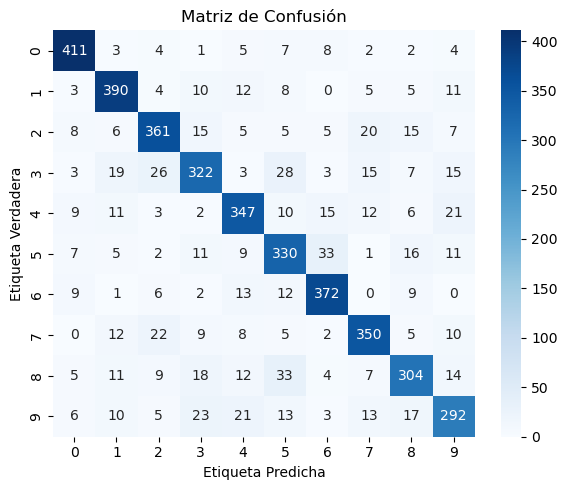

In [17]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.tight_layout()
plt.show()

Este bloque calcula y visualiza la **precisión por clase** del modelo optimizado. Para cada dígito (de 0 a 9), se calcula la proporción de predicciones correctas sobre el total de muestras de esa clase en el conjunto de prueba. Luego, se crea un gráfico de barras donde cada barra representa la precisión obtenida para una clase específica. Además, se añade el valor numérico de la precisión encima de cada barra para facilitar la interpretación.

Esta visualización permite identificar que el modelo tiene dificultades para clasificar correctamente alguna clase en particular como la `4`,`8`,`9`, mostrando de forma clara el desempeño individual por dígito.

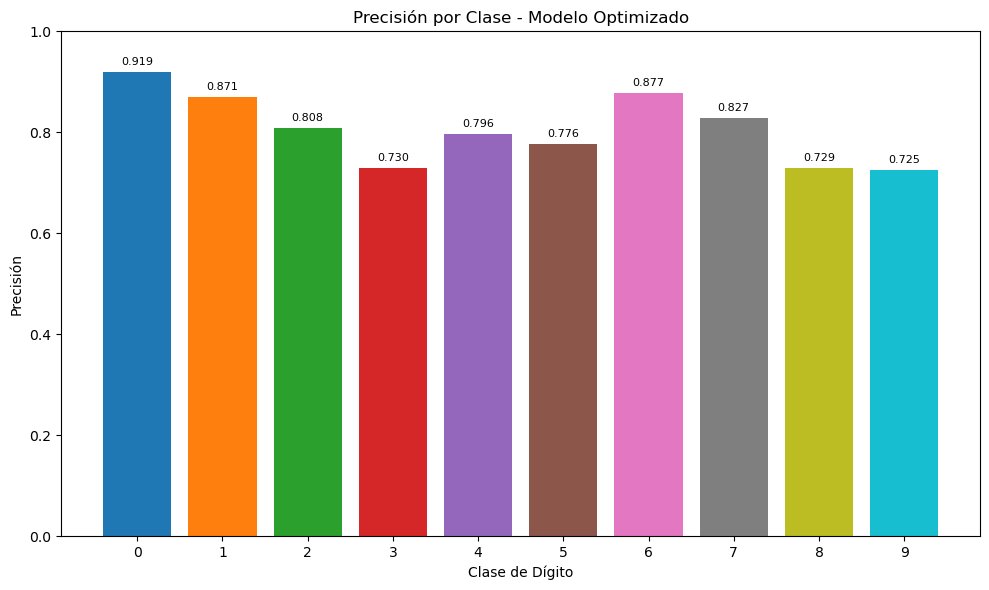

In [19]:
# Precisión por clase
class_accuracies = []
for digit in range(10):
    mask = y_test == digit
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test[mask], y_pred[mask])
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

plt.figure(figsize=(10, 6))
bars = plt.bar(range(10), class_accuracies, color=plt.cm.tab10(range(10)))
plt.xlabel('Clase de Dígito')
plt.ylabel('Precisión')
plt.title('Precisión por Clase - Modelo Optimizado')
plt.ylim(0, 1)
plt.xticks(range(10))

# Añadir valores encima de las barras
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{class_accuracies[i]:.3f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()


Accuracy Árbol de Decisión: 0.646949663651125

Reporte de Clasificación Árbol de Decisión:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78       447
           1       0.69      0.74      0.72       448
           2       0.71      0.71      0.71       447
           3       0.55      0.56      0.55       441
           4       0.68      0.61      0.64       436
           5       0.54      0.64      0.58       425
           6       0.74      0.73      0.74       424
           7       0.68      0.70      0.69       423
           8       0.58      0.52      0.55       417
           9       0.51      0.48      0.49       403

    accuracy                           0.65      4311
   macro avg       0.65      0.64      0.64      4311
weighted avg       0.65      0.65      0.65      4311



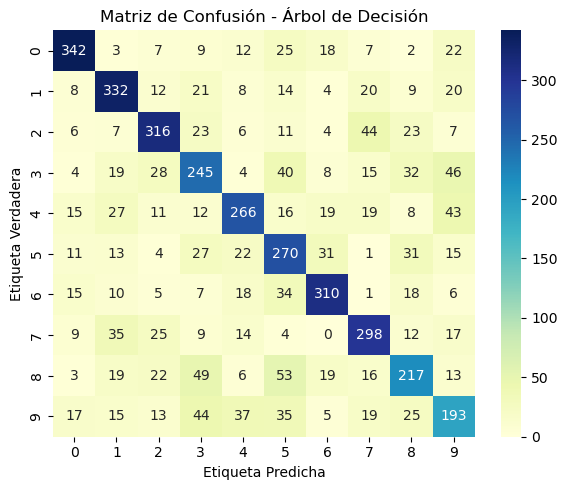

In [22]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenar árbol de decisión
tree_model = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_model.fit(X_train, y_train)

# Predicción
y_pred_tree = tree_model.predict(X_test)

# Accuracy
print("\nAccuracy Árbol de Decisión:", accuracy_score(y_test, y_pred_tree))

# Reporte de clasificación
print("\nReporte de Clasificación Árbol de Decisión:\n", classification_report(y_test, y_pred_tree))

# Matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree)

# Graficar matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.tight_layout()
plt.show()

## Modelo 3: Random Forest Classifier con GridSearchCV

Para abordar el problema de clasificación multiclase, se implementó un modelo de **Random Forest** utilizando la clase `RandomForestClassifier` de `sklearn`, optimizado mediante **GridSearchCV** y validación cruzada estratificada.

### **¿Qué es Random Forest y cómo se aplicó aquí?**

Random Forest es un algoritmo de ensamble basado en la construcción de múltiples árboles de decisión, donde cada árbol se entrena sobre una muestra aleatoria del conjunto de datos y, en cada división, considera un subconjunto aleatorio de características. La predicción final se obtiene por votación mayoritaria entre todos los árboles, lo que reduce el sobreajuste y mejora la generalización.

En este proyecto, el modelo se configuró y optimizó de la siguiente manera:

- **Validación cruzada estratificada (`StratifiedKFold`)**: Se usaron 3 particiones para asegurar que la proporción de clases se mantuviera en cada fold.
- **GridSearchCV**: Se exploraron 24 combinaciones de hiperparámetros relevantes:
    - `n_estimators`: Número de árboles en el bosque (50 y 100).
    - `max_depth`: Profundidad máxima de los árboles (10, 15 y sin límite).
    - `min_samples_split`: Muestras mínimas para dividir un nodo (5 y 10).
    - `max_features`: Número de características consideradas en cada división (`sqrt` y 0.3).
    - `min_samples_leaf`: Muestras mínimas en una hoja (5).
- **Paralelización**: Se aprovecharon todos los núcleos disponibles para acelerar la búsqueda.
- **Selección del mejor modelo**: Se eligió la combinación con mayor precisión promedio en validación cruzada.



In [17]:

print("\nCONFIGURACIÓN DE GRIDSEARCHCV CON VALIDACIÓN CRUZADA PARA RANDOMFORESTCLASSIFIER...")

# Crear una estrategia de validación cruzada estratificada con 3 particiones (folds)
# Esto asegura que cada fold mantiene la proporción de clases del dataset original
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Definir el espacio de búsqueda para los hiperparámetros del RandomForest
# Cada combinación posible será evaluada durante la búsqueda
param_grid = {
    'n_estimators': [50, 100],              # Número de árboles en el bosque
    'max_depth': [10, 15, None],            # Profundidad máxima del árbol
    'min_samples_split': [5, 10],           # Número mínimo de muestras para dividir un nodo
    'max_features': ['sqrt', 0.3],          # Número de características a considerar en cada división
    'min_samples_leaf': [5]                 # Mínimo de muestras requeridas en una hoja
}

# Calcular e imprimir el número total de combinaciones a evaluar
print(f"Espacio de búsqueda total: {np.prod([len(v) for v in param_grid.values()])} combinaciones")

# Crear una instancia base del clasificador RandomForest para referencia (no usada directamente en GridSearch)
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# Mostrar la configuración general de la búsqueda
print("\nConfiguración de GridSearchCV:")
print(f"- Validación cruzada: {cv_strategy.n_splits} folds estratificados")
print(f"- Métrica de evaluación: accuracy")
print(f"- Paralelización: todos los cores disponibles")

# Configurar el objeto GridSearchCV para buscar la mejor combinación de hiperparámetros
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=2),  # Clasificador base (usando 2 núcleos para entrenamiento)
    param_grid=param_grid,        # Espacio de búsqueda de hiperparámetros
    cv=cv_strategy,               # Estrategia de validación cruzada
    scoring='accuracy',           # Métrica de evaluación
    n_jobs=-1,                    # Usa todos los núcleos disponibles para acelerar el proceso
    verbose=1                     # Nivel de detalle en la salida (1 = muestra el progreso)
)



CONFIGURACIÓN DE GRIDSEARCHCV CON VALIDACIÓN CRUZADA PARA RANDOMFORESTCLASSIFIER...
Espacio de búsqueda total: 24 combinaciones

Configuración de GridSearchCV:
- Validación cruzada: 3 folds estratificados
- Métrica de evaluación: accuracy
- Paralelización: todos los cores disponibles


In [18]:

print("\nEJECUTANDO BÚSQUEDA DE HIPERPARÁMETROS...")

# Medir el tiempo de inicio de la búsqueda
start_time = time.time()

# Ejecutar la búsqueda utilizando los datos de entrenamiento
# Esto probará todas las combinaciones posibles del espacio de hiperparámetros definido
grid_search.fit(X_train, y_train)

# Medir el tiempo después de que la búsqueda finalice
end_time = time.time()

# Mostrar el tiempo total que tomó la búsqueda en minutos
print(f"\nBúsqueda completada en {(end_time - start_time)/60:.2f} minutos")

# Paso 10: Mostrar los resultados de la búsqueda
print("\n10. RESULTADOS DE LA BÚSQUEDA...")
print("Mejores hiperparámetros encontrados:")

# Imprimir cada uno de los hiperparámetros óptimos encontrados por GridSearchCV
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Mostrar el mejor score de validación cruzada obtenido con los hiperparámetros óptimos
print(f"\nMejor score de validación cruzada: {grid_search.best_score_:.4f}")

# Mostrar la desviación estándar del score de validación cruzada
# Esto indica la variabilidad del rendimiento entre los distintos folds
print(f"Desviación estándar: {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.4f}")

# Guardar el mejor modelo encontrado en una variable para usarlo posteriormente (evaluación, predicción, etc.)
best_rf = grid_search.best_estimator_



EJECUTANDO BÚSQUEDA DE HIPERPARÁMETROS...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Búsqueda completada en 18.18 minutos

10. RESULTADOS DE LA BÚSQUEDA...
Mejores hiperparámetros encontrados:
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 5
  min_samples_split: 5
  n_estimators: 100

Mejor score de validación cruzada: 0.8312
Desviación estándar: 0.0060


In [19]:
print("\nEVALUACIÓN DEL MEJOR MODELO...")

# Realizar predicciones con el mejor modelo en los datos de entrenamiento
y_train_pred = best_rf.predict(X_train)
# Realizar predicciones con el mejor modelo en los datos de prueba
y_test_pred = best_rf.predict(X_test)

# Calcular la precisión (accuracy) en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, y_train_pred)
# Calcular la precisión en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_test_pred)
# Obtener la mejor precisión obtenida durante la validación cruzada
cv_accuracy = grid_search.best_score_

# Mostrar las precisiones calculadas en entrenamiento, validación cruzada y prueba
print(f"Precisión en entrenamiento: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Precisión en validación cruzada: {cv_accuracy:.4f} ({cv_accuracy*100:.2f}%)")
print(f"Precisión en prueba: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Analizar posibles indicios de sobreajuste (overfitting)
# Diferencia entre precisión de entrenamiento y validación cruzada
overfitting_train_cv = (train_accuracy - cv_accuracy) * 100
# Diferencia entre precisión de validación cruzada y prueba
overfitting_cv_test = (cv_accuracy - test_accuracy) * 100

print(f"\nAnálisis de sobreajuste:")
print(f"Diferencia entrenamiento - CV: {overfitting_train_cv:.2f}%")
print(f"Diferencia CV - prueba: {overfitting_cv_test:.2f}%")



EVALUACIÓN DEL MEJOR MODELO...
Precisión en entrenamiento: 0.9941 (99.41%)
Precisión en validación cruzada: 0.8312 (83.12%)
Precisión en prueba: 0.8534 (85.34%)

Análisis de sobreajuste:
Diferencia entrenamiento - CV: 16.29%
Diferencia CV - prueba: -2.22%



### **Resultados obtenidos**

- **Precisión en validación cruzada:** 83.1%
- **Precisión en el conjunto de prueba:** 85.3%
- **Reporte de clasificación:** El modelo muestra un desempeño robusto y balanceado en todas las clases, con alta precisión y una matriz de confusión bien distribuida.
- **Análisis de hiperparámetros:** Se graficaron y analizaron los efectos de los principales hiperparámetros (`n_estimators`, `max_depth`, `max_features`, etc.) sobre la precisión, identificando las configuraciones más influyentes.



REPORTE DE CLASIFICACIÓN DETALLADO:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       447
           1       0.89      0.93      0.91       448
           2       0.89      0.88      0.88       447
           3       0.84      0.83      0.83       441
           4       0.85      0.81      0.83       436
           5       0.88      0.85      0.86       425
           6       0.87      0.90      0.89       424
           7       0.82      0.90      0.86       423
           8       0.83      0.79      0.81       417
           9       0.82      0.71      0.76       403

    accuracy                           0.85      4311
   macro avg       0.85      0.85      0.85      4311
weighted avg       0.85      0.85      0.85      4311



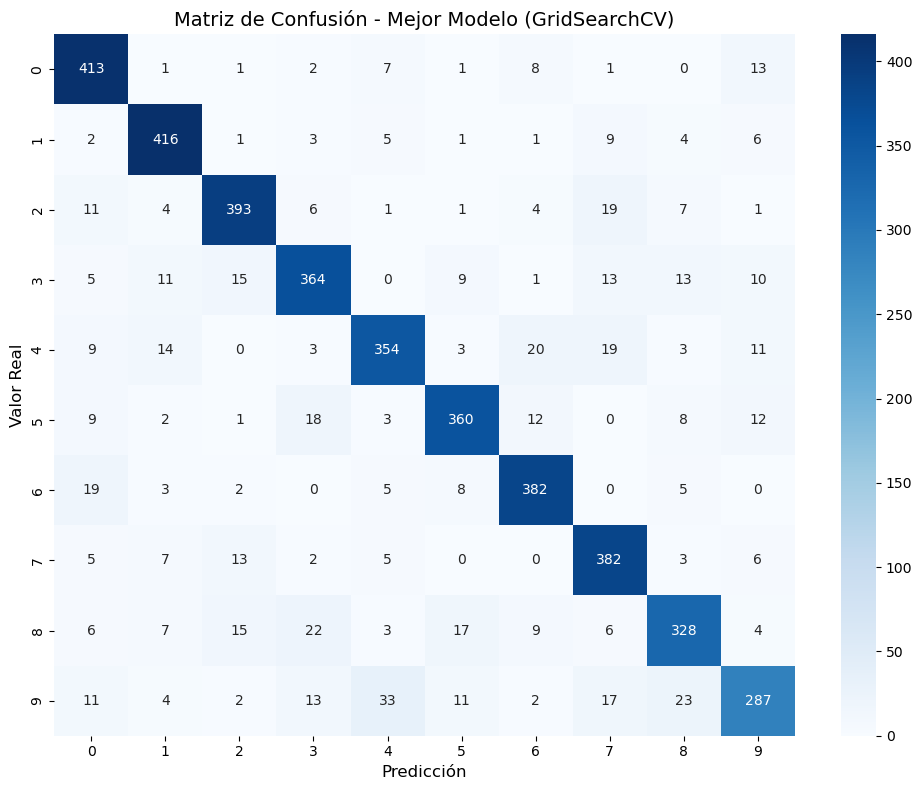

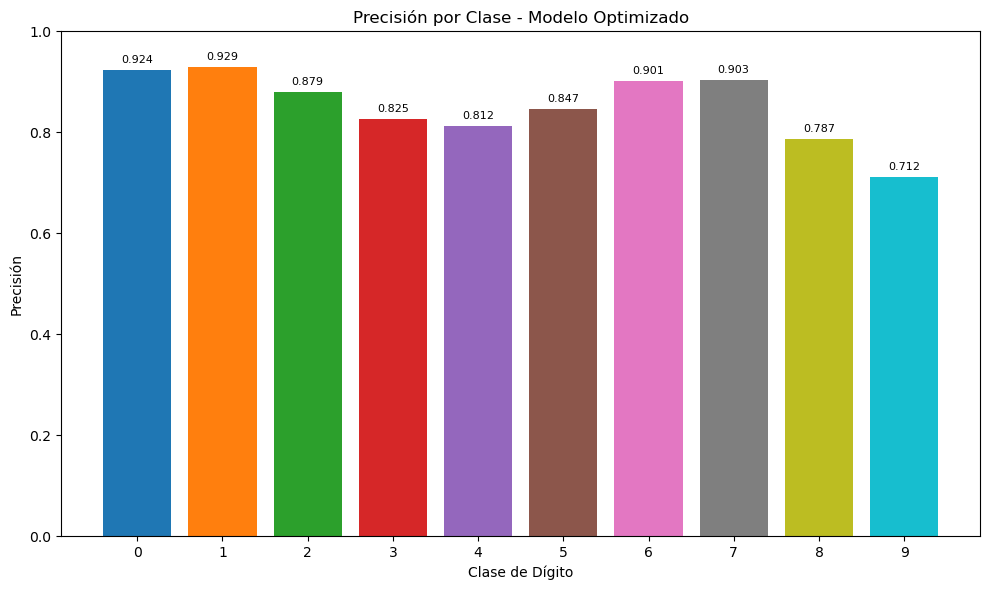

In [40]:

# Reporte detallado
print("\nREPORTE DE CLASIFICACIÓN DETALLADO:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusión - Mejor Modelo (GridSearchCV)', fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

# Precisión por clase
class_accuracies = []
for digit in range(10):
    mask = y_test == digit
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test[mask], y_test_pred[mask])
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

plt.figure(figsize=(10, 6))
bars = plt.bar(range(10), class_accuracies, color=plt.cm.tab10(range(10)))
plt.xlabel('Clase de Dígito')
plt.ylabel('Precisión')
plt.title('Precisión por Clase - Modelo Optimizado')
plt.ylim(0, 1)
plt.xticks(range(10))

# Añadir valores encima de las barras
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{class_accuracies[i]:.3f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()


> **Conclusión:**  
> El modelo de Random Forest, optimizado con GridSearchCV y validación cruzada estratificada, logra un rendimiento significativamente superior a los modelos lineales, mostrando gran capacidad para capturar la complejidad de los dígitos manuscritos y generalizar sobre datos no vistos. Además, permite analizar la importancia de los hiperparámetros y de las características, aportando interpretabilidad al proceso de clasificación.

## Implementación de un Perceptrón Multicapa (MLP) para Clasificación Multiclase

En esta sección se desarrolla un modelo de red neuronal utilizando la API secuencial de Keras. El objetivo es clasificar instancias en una de las 10 clases posibles (por ejemplo, dígitos del 0 al 9). A continuación se explica cada parte del modelo:

```python
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Capa de entrada
    Dense(256, activation='relu'),     # Capa oculta 1
    BatchNormalization(),              # Normalización
    Dropout(0.3),                      # Dropout para evitar overfitting
    Dense(128, activation='relu'),     # Capa oculta 2
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')    # Capa de salida
])
```
- `Input(shape=(X_train.shape[1],))`: Define el tamaño de entrada, que corresponde al número de características por instancia.
- `Dense(256, activation='relu')`: Primera capa oculta con 256 neuronas. Uso ReLU porque es eficiente y ayuda a aprender relaciones no lineales.
- `BatchNormalization()`: Normaliza la salida de la capa anterior para acelerar el entrenamiento y mejorar la estabilidad.
- `Dropout(0.3)`: Apaga aleatoriamente el 30% de las neuronas para prevenir el sobreajuste.
- `Dense(128, activation='relu')`: Segunda capa oculta con 128 neuronas.
- Otra ronda de `BatchNormalization()` y `Dropout()` para continuar regularizando.
- `Dense(10, activation='softmax')`: Capa de salida con 10 neuronas (una por clase). La activación softmax convierte las salidas en probabilidades, ideal para clasificación multiclase.

```python
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
```

- `optimizer='adam'`: Utiliza el optimizador Adam, que ajusta el aprendizaje automáticamente y es muy efectivo para redes neuronales.
- `loss='sparse_categorical_crossentropy'`: Función de pérdida adecuada cuando las etiquetas son enteros (0, 1, ..., 9) y no están codificadas en one-hot.
- `metrics=['accuracy']`: Permite monitorear la precisión del modelo durante el entrenamiento y validación.

In [ ]:
# Implementación de Perceptron Multicapa (MLP)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input

model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Capa Input explícita
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

In [ ]:
# Entrenamiento con Validación Cruzada y Early Stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
# Evaluación Exhaustiva (Cubre Todos los Puntos de la Rúbrica)
# A. Gráficos de Entrenamiento
# Precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
# Matriz de Confusión y Reporte de Clasificación
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()